<img src="https://www.digitalhouse.com/logo-DH.png" width="200" height="100" align="left">

<h3><b>Curso:</b> Data Science / <b>Año:</b> 2020 / <b>Sede:</b> Casa</h3>

-----

<h3><b>TP Integrador:</b> Text Mining de <i>tweets</i> de anuncios del gobierno durante la cuarentena.</h3>
<blockquote>
        <ul>
          <li><i>Sentiment analysis</i> de los comentarios de los usuarios.</li>
          <li>Clustering de <i>tweets</i> de los usuarios.</li>
        </ul>
</blockquote>

<h3><b>Grupo 10:</b></h3>
<blockquote>
        <ul>
          <li>Maria Eugenia Perotti</li>
          <li>Gastón Ortíz</li>
        </ul>
</blockquote>

# Modelo de clasificación.

En base a los tweets, vamos a tratar de predecir el sentimiento respecto de la cuarentena con las siguientes etiquetas:
* Positivo = A favor de la cuarentena.
* Negativo = En contra de la cuarentena.
* Neutral = No emite opinión.

# Preparación de libraries y funciones.
## Imports.

In [38]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import spacy
import string
import time

from sklearn.base import TransformerMixin
from sklearn.cluster import DBSCAN,KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import Isomap, TSNE
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline, make_union, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

from spacy.lang.es import Spanish
from spacy.lang.es.stop_words import STOP_WORDS
from spacy import displacy

from textblob import TextBlob

# settings colab:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ModuleNotFoundError:    
    print("Se está trabajando localmente")

Se está trabajando localmente


## Definición de funciones.
En esta sección definimos las funciones que vamos a utilizar en la notebook.

### Función para Tokenizar los datos con spaCy

Usaremos esta función para eliminar automáticamente la información que no necesitamos, como palabras vacías y puntuación, de cada tweet.

Primero importamos los modelos de Español y el módulo de string de Python, que contiene una lista de todos los signos de puntuación que podemos usar en `string.punctuation`. Crearemos variables que contienen los signos de puntuación y las palabras vacías que queremos eliminar, y un analizador que ejecuta la entrada a través del módulo de español de spaCy.

Luego, crearemos una función `spacy_tokenizer()` que acepta una oración como entrada y procesa la oración en _tokens_, realizando lematización, pasando todo a minúsculas y eliminando palabras vacías. 

In [39]:
# Creamos nuestra lista de signos de puntuación.
punctuations = string.punctuation

# Creamos nuestra lista de stopwords
nlp = spacy.load("es_core_news_sm")
stop_words = spacy.lang.es.stop_words.STOP_WORDS

# Cargamos el tokenizador, tagger, parser, NER y los word vectors del Español.
parser = Spanish()

def spacy_tokenizer(sentence):
    # Creamos nuestro objeto token, que va a ser utilizado para crear documentos con anotaciones lingüísticas.
    mytokens = parser(sentence)

    # Lematizamos cada token y lo pasamos a minúsculas.
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Sacamos las stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # retorna la lista de tokens preprocesada
    return mytokens

### Definición de un Transformer custom.
Para continuar limpiando nuestros datos, creamos un transformador personalizado para eliminar los espacios iniciales y finales y convertir el texto en minúsculas. Aquí, crearemos una clase personalizada `predictors` que hereda de la clase `TransformerMixin`. Esta clase anula los métodos transform, fit y get_parrams. También crearemos una función `clean_text()` que elimina los espacios y convierte el texto en minúsculas.

In [40]:
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

### Vectorization Feature Engineering (TF-IDF)
Generamos una matriz de Bag of words para nuestros datos de texto utilizando `CountVectorizer` de scikit-learn y le decimos que use nuestra función `spacy_tokenizer` como su tokenizador, y definiendo el rango de n-gramas que queremos.

El parámetro `ngram_range` establece los límites inferior y superior de nuestros n-gramas (usaremos unigrams). Luego asignaremos los n-gramas a una variable bow_vector.

In [41]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

También nos interesa mirar el **TF-IDF** de nuestros términos, ya que podemosa saber qué tan importante es un término en particular en el contexto de un documento dado, basado en cuántas veces aparece el término y en cuántos otros tweets aparece ese mismo término. Cuanto mayor sea el **TF-IDF**, más importante es ese término para ese tweet.

Generamos el TF-IDF automáticamente usando `TfidfVectorizer` de scikit-learn. Nuevamente, le diremos que use el tokenizador personalizado que creamos con spaCy, y luego asignaremos el resultado a la variable `tfidf_vector`.

In [42]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

### Impresión de resultados.

En esta sección definiremos las funciones a reutilizar para imprimir los resultados de las prediciones.

#### Función para mostrar las Métricas de clasificación.

In [43]:
def print_classification_report(y_test, y_pred):
    print(classification_report(y_test, y_pred))

## EDA.

Vemos cómo está distribuida la muestra que tenemos.

<AxesSubplot:title={'center':'Distribución de sentimiento'}, ylabel='sentimiento'>

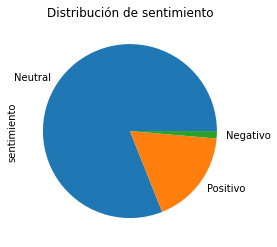

In [27]:
plt.title('Distribución de sentimiento')
df.sentimiento.value_counts().plot(kind='pie')

# Text mining.

## Preprocesamiento.

### Quitamos los nulos.

In [28]:
df.dropna(subset=['sentimiento'], inplace=True)

In [29]:
df.shape

(807, 6)

## Primera prueba: sin imputar clasificaciones en base a palabras.

### Dividimos los datos en Training y Test.

In [30]:
X = df['tweet']
y = df['sentimiento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

### Creación del Pipeline y Generación del modelo.
Ya podemos construir nuestro modelo con Multinomial Naive Bayes.

Luego, crearemos un _pipeline_ con tres componentes: un limpiador, un vectorizador y un clasificador. El limpiador usa nuestra clase `predictors` para limpiar y preprocesar el texto. El vectorizador usa objetos `bow_vector` para crear la matriz de BoW para nuestro texto. El clasificador de por sí realiza la clasificación de los sentimientos.

In [31]:
classifier = MultinomialNB()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x0000013930C91520>),
                ('vectorizer',
                 CountVectorizer(tokenizer=<function spacy_tokenizer at 0x000001391DDD1B80>)),
                ('classifier', MultinomialNB())])

### Evaluación del Modelo.

In [32]:
y_pred = pipe.predict(X_test)

print_classification_report(y_test, y_pred)

              precision    recall  f1-score   support

    Negativo       0.00      0.00      0.00         3
     Neutral       0.88      1.00      0.93       197
    Positivo       1.00      0.42      0.59        43

    accuracy                           0.88       243
   macro avg       0.63      0.47      0.51       243
weighted avg       0.89      0.88      0.86       243



C:\Users\Manu\anaconda3\envs\tweets\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Segunda prueba: imputando clasificaciones en base a palabras.

Imputaciones en base a palabras.

In [33]:
lexicon_negativo = ['']
lexicon_positivo = ['']

# Conclusiones.


# Fuentes.

https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/